In [1]:
import oommfc as oc
import discretisedfield as df
import micromagneticmodel as mm
import micromagneticdata as md
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

sysName = "P1"

## Material parameters and other general definitions

In [2]:
# Conversion factors
Oe = 1000/(4*np.pi)     # conversion Oe->A/m 79.577471/ 1 mT->10 Oe

# magnetic parametes
alpha_YIG = 1.75e-4    # Gilbert damping (-)

Ms_YIG = 140.7e3           # Saturation magnetisation (A/m). 

A_YIG = 4.22e-12           # Exchange stiffness (J/m)

l_ex = (2*A_YIG/(mm.consts.mu0*Ms_YIG**2)) # Exchange length (m)


## Sample and mesh cell creation

In [3]:
# Geometry [m]
l = 30e-6 #60e-6
w = 500e-9
t = 50e-9

# self absorbing boundary condition
band = 0.25e-6

sourceWidth=40e-9 #cercare bene la misura sul righello
sourcePos=band #almeno iniettiamo le waves nel bulk, possiamo modificare

# Mesh cell [m]
cx = 50e-9   #50e-9
cy = w  #50e-9
cz = t

cell = (cx, cy, cz)

# Zeeman field
Hx = 50 * Oe
Hy = 0
Hz = 0
H_DC = (Hx, Hy, Hz)

# Initial magnetization
m0 = (1, 0, 0)   # Initial reduced magnetization

# w0 = mm.consts.gamma0*mm.consts.mu0*(Hx/Oe)
# wM = mm.consts.gamma0*mm.consts.mu0*Ms_YIG

# print(np.sqrt(w0*wM+w0**2))
# print(wM)
# print(w0)

## Energy and boundary conditions definition

In [4]:
# demagnetizing energy
dem = mm.Demag()
# exchange energy
ex = mm.Exchange(A=A_YIG)
# zeeman energy
zem = mm.Zeeman(H=H_DC, name='bias')

mn = oc.MinDriver()           # minimization driver
td = oc.TimeDriver()          # time driver


## System definition

In [5]:
system = mm.System(name=sysName)
region = df.Region(p1=(-l, -w/2, 0), p2=(l, w/2, t))
mesh = df.Mesh(region=region, cell=cell)

def alpha_abs(point):
    x, y, z = point
    if (-l/2 < x < -l/2+band):
        return (((x+l/2-band)**2)/(band)**2+alpha_YIG)

    if (l/2-band < x < l/2):
        return (((x-l/2+band)**2)/(band)**2+alpha_YIG)

    else:
        return (alpha_YIG)


alpha = df.Field(mesh, nvdim=1, value=alpha_abs)


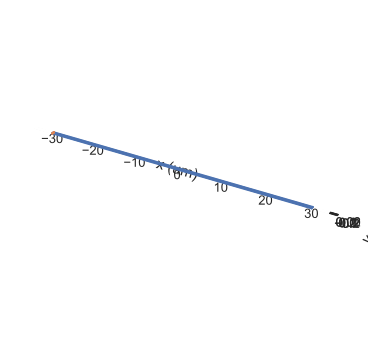

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
mesh.mpl(ax=ax)

# Get the current z-axis bounds
z_bounds = ax.get_zbound()

# Set the new z-axis bounds
ax.set_zbound([z_bounds[0], z_bounds[1]*0.5])
ax.zaxis.set_major_locator(ticker.MultipleLocator(base=0.02))

plt.show()

#mesh.mpl(figsize=(30, 10))

## System initialization

In [7]:
# macro to return correct saturation magnetisation inside or outside the sample
def Ms_value(pos):
    # from 0, only inside the sample
    x, y, z = pos

    if (-l/2 < x < l/2 and -w/2 < y < w/2 and 0 < z < t):                                        # rect
        return Ms_YIG

    else:                                                                    # empty space
        return 0


system.m = df.Field(mesh, nvdim=3, value=m0, norm=Ms_value)

## Check system current state

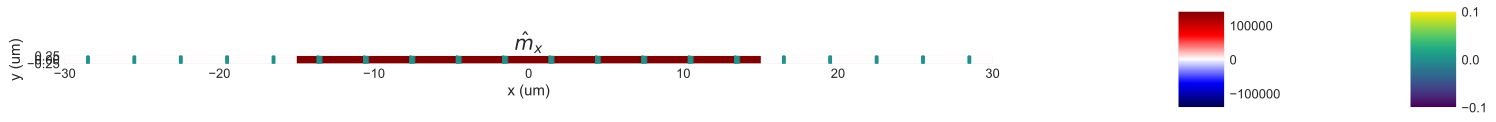

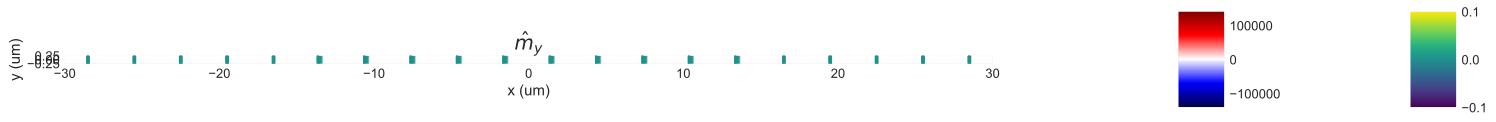

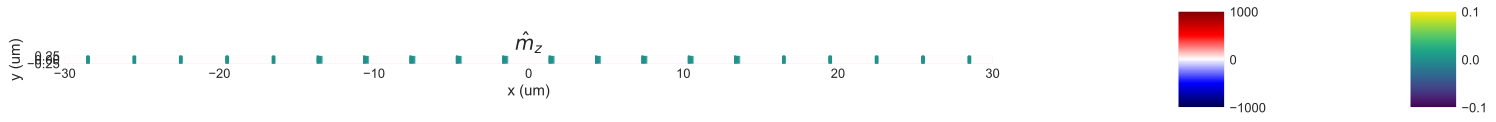

In [8]:
fig,ax =plt.subplots(figsize=(25,10))

plt.title('$\hat m_x$')
"""
    system.m accesses the megnetization
    m.x accesses the x component
    x.sel("z") means "sliced at a fixed value of z", by defaut the middle of the system
    from mpl.scalar on it's just about putting the red/blue color code on the right
    """
system.m.x.sel('z').mpl.scalar(ax=ax,vmin=-Ms_YIG,vmax=Ms_YIG,cmap='seismic')

system.m.sel('z').resample((20,10)).mpl.vector(ax=ax,headwidth=3,scale=2e7)
"""
    this basically just shows the vaues of the vector field m, as colored dots/arrows. 
    Uses the matplotlib.quiver method
    for low fields you only see yellow dots since the equilibrium magnetization is parallel to z
    """



fig,ax =plt.subplots(figsize=(25,10))
plt.title('$\hat m_y$')
system.m.y.sel('z').mpl.scalar(ax=ax,vmin=-Ms_YIG,vmax=Ms_YIG,cmap='seismic')
system.m.sel('z').resample((20,10)).mpl.vector(ax=ax,headwidth=3,scale=2e7)

fig,ax =plt.subplots(figsize=(25,10))
plt.title('$\hat m_z$')
system.m.z.sel('z').mpl.scalar(ax=ax,vmin=-1000,vmax=1000,cmap='seismic')
system.m.sel('z').resample((20,10)).mpl.vector(ax=ax,headwidth=3,scale=2e7)

## Drive to equilibrium state

In [9]:
# get system to equilibrium
system.energy = dem + ex + zem
mn.drive(system)

damping = mm.Damping(alpha=alpha_YIG)
system.dynamics = mm.Precession(gamma0=mm.consts.gamma0) + damping

Running OOMMF (ExeOOMMFRunner)[2024/01/25 11:28]... (5.7 s)


## RF injection and time simulation settings definition

In [10]:
# inject RF field and time sim
T = 200e-9 #100e-9
f_MAX = 4.6e9

f_Nyquist = 2*f_MAX
n_Nyquist = T*f_Nyquist
n_oversampling = 50
sampling = int(n_Nyquist+n_oversampling)
t_0 = T/sampling



In [11]:

def Hspace_RF(point):
    x, y, z = point
    if (-l/2+sourcePos< x < -l/2+sourcePos+sourceWidth and -w/2 < y < w/2 and 0 < z < t):
        return (0, 0, 10*Oe)
    else:
        return (0, 0, 0)


H_RF = df.Field(mesh, nvdim=3, value=Hspace_RF)
zemRF = mm.Zeeman(H=H_RF, func='sinc', f=f_MAX, t0=T/sampling, name='RF')
try:
    system.energy += zemRF
finally:
    td.drive(system, t=T, n=sampling, n_threads=19, verbose=2)

Running OOMMF (ExeOOMMFRunner):   0%|          | 0/1890 files written [00:00]

Running OOMMF (ExeOOMMFRunner)[2024/01/25 11:28] took 24.2 s


In [12]:
system.table.data

,E,E_calc_count,max_dm/dt,dE/dt,delta_E,E_demag,E_exchange,max_spin_ang_exchange,stage_max_spin_ang_exchange,run_max_spin_ang_exchange,E_zeeman_bias,E_RF,iteration,stage_iteration,stage,mx,my,mz,last_time_step,t
0,-5.102026e-16,25.0,7.079556,-3.149639e-15,-8.406578e-23,1.742260e-17,3.711231e-22,0.530800,0.530800,0.530800,-5.276250e-16,-6.320744e-22,3.0,3.0,0.0,1.000000,0.000017,0.000003,5.420715e-11,1.058201e-10
1,-5.102012e-16,38.0,12.896454,1.651662e-11,5.945012e-22,1.742313e-17,6.683091e-22,0.657422,0.674309,0.674309,-5.276249e-16,-4.637011e-23,6.0,2.0,1.0,1.000000,0.000016,0.000011,3.006148e-11,2.116402e-10
2,-5.102008e-16,51.0,8.035780,1.893936e-12,8.492368e-24,1.742296e-17,1.115633e-21,0.800408,0.871431,0.871431,-5.276249e-16,-1.075921e-23,9.0,2.0,2.0,1.000000,-0.000023,0.000010,3.006148e-11,3.174603e-10
3,-5.102008e-16,64.0,6.462833,-1.778488e-12,-6.065821e-23,1.742286e-17,1.209680e-21,0.646862,0.800408,0.871431,-5.276249e-16,1.516121e-23,12.0,2.0,3.0,1.000000,-0.000033,-0.000001,3.006148e-11,4.232804e-10
4,-5.102008e-16,77.0,7.953286,-5.301838e-13,-1.526940e-23,1.742298e-17,1.096771e-21,0.590241,0.646862,0.871431,-5.276249e-16,6.027668e-24,15.0,2.0,4.0,1.000000,-0.000015,-0.000010,3.006148e-11,5.291005e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1885,-5.105691e-16,35804.0,30.992035,-2.330958e-12,-3.537098e-23,1.536625e-17,9.316148e-19,17.102165,17.790225,22.842578,-5.268670e-16,7.502987e-26,7071.0,3.0,1885.0,0.998563,-0.004365,0.000192,1.518836e-11,1.995767e-07
1886,-5.105692e-16,35823.0,26.946943,-2.272430e-12,-3.158855e-23,1.530200e-17,9.318859e-19,16.710093,17.102165,22.842578,-5.268031e-16,2.257846e-26,7075.0,3.0,1886.0,0.998442,-0.004728,0.000116,1.391122e-11,1.996825e-07
1887,-5.105694e-16,35842.0,38.846227,-2.182340e-12,-3.362096e-23,1.529027e-17,9.431844e-19,16.766208,16.965481,22.842578,-5.268028e-16,-2.581722e-26,7079.0,3.0,1887.0,0.998442,-0.004842,-0.000041,1.543138e-11,1.997884e-07
1888,-5.105695e-16,35867.0,32.658574,-2.429085e-12,-3.303738e-23,1.538827e-17,9.127868e-19,18.087251,18.108244,22.842578,-5.268705e-16,-1.788972e-26,7083.0,3.0,1888.0,0.998570,-0.004604,-0.000192,1.364508e-11,1.998942e-07


In [13]:
data = md.Data(sysName)[-1]

array = data.to_xarray()

data.info

{'drive_number': 46,
 'date': '2024-01-25',
 'time': '11:28:24',
 'driver': 'TimeDriver',
 't': 2e-07,
 'n': 1890,
 'n_threads': 19}

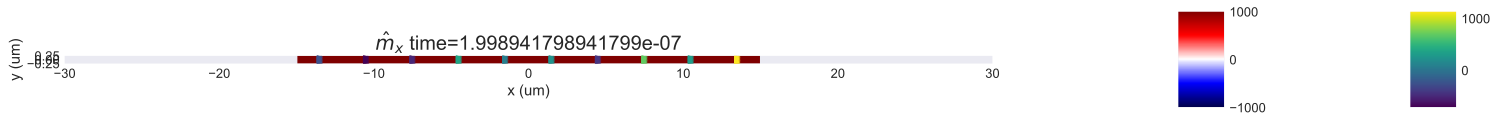

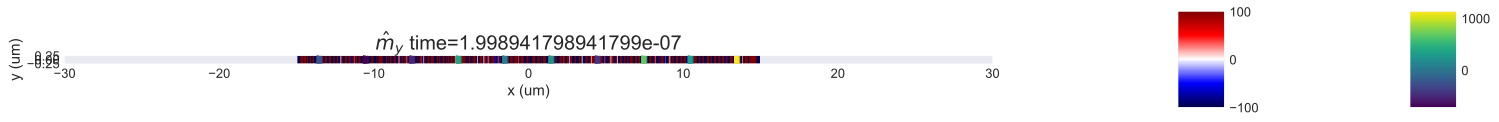

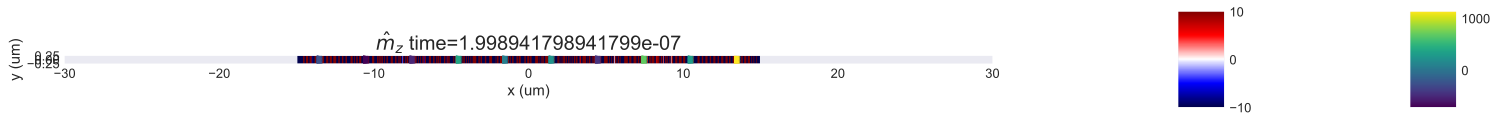

In [14]:
fig,ax =plt.subplots(figsize=(25,10))

plt.title('$\hat m_x$ time='+str((sampling-1)*t_0))
data[sampling-1].x.sel('z').mpl.scalar(ax=ax,vmin=-1000,vmax=1000,cmap='seismic')
data[sampling-1].sel('z').resample((20,10)).mpl.vector(ax=ax,headwidth=3,scale=2e7)

fig,ax =plt.subplots(figsize=(25,10))
plt.title('$\hat m_y$ time='+str((sampling-1)*t_0))
data[sampling-1].y.sel('z').mpl.scalar(ax=ax,vmin=-100,vmax=100,cmap='seismic')
data[sampling-1].sel('z').resample((20,10)).mpl.vector(ax=ax,headwidth=3,scale=2e7)

fig,ax =plt.subplots(figsize=(25,10))
plt.title('$\hat m_z$ time='+str((sampling-1)*t_0))
data[sampling-1].z.sel('z').mpl.scalar(ax=ax,vmin=-10,vmax=10,cmap='seismic')
data[sampling-1].sel('z').resample((20,10)).mpl.vector(ax=ax,headwidth=3,scale=2e7)

plt.show()

In [15]:
table = data.table

table.data 
# fig = plt.figure(figsize=(20,10))
# ax = fig.add_subplot(111)

# table.mpl(ax=ax, y=['max_spin_ang_exchange', "run_max_spin_ang_exchange", "E_RF"])
# ax.legend(['Iteration Max Spin Angle', 'Run Max Spin Angle'])
# ax.set_ylabel("Angle (deg")


,E,E_calc_count,max_dm/dt,dE/dt,delta_E,E_demag,E_exchange,max_spin_ang_exchange,stage_max_spin_ang_exchange,run_max_spin_ang_exchange,E_zeeman_bias,E_RF,iteration,stage_iteration,stage,mx,my,mz,last_time_step,t
0,-5.102026e-16,25.0,7.079556,-3.149639e-15,-8.406578e-23,1.742260e-17,3.711231e-22,0.530800,0.530800,0.530800,-5.276250e-16,-6.320744e-22,3.0,3.0,0.0,1.000000,0.000017,0.000003,5.420715e-11,1.058201e-10
1,-5.102012e-16,38.0,12.896454,1.651662e-11,5.945012e-22,1.742313e-17,6.683091e-22,0.657422,0.674309,0.674309,-5.276249e-16,-4.637011e-23,6.0,2.0,1.0,1.000000,0.000016,0.000011,3.006148e-11,2.116402e-10
2,-5.102008e-16,51.0,8.035780,1.893936e-12,8.492368e-24,1.742296e-17,1.115633e-21,0.800408,0.871431,0.871431,-5.276249e-16,-1.075921e-23,9.0,2.0,2.0,1.000000,-0.000023,0.000010,3.006148e-11,3.174603e-10
3,-5.102008e-16,64.0,6.462833,-1.778488e-12,-6.065821e-23,1.742286e-17,1.209680e-21,0.646862,0.800408,0.871431,-5.276249e-16,1.516121e-23,12.0,2.0,3.0,1.000000,-0.000033,-0.000001,3.006148e-11,4.232804e-10
4,-5.102008e-16,77.0,7.953286,-5.301838e-13,-1.526940e-23,1.742298e-17,1.096771e-21,0.590241,0.646862,0.871431,-5.276249e-16,6.027668e-24,15.0,2.0,4.0,1.000000,-0.000015,-0.000010,3.006148e-11,5.291005e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1885,-5.105691e-16,35804.0,30.992035,-2.330958e-12,-3.537098e-23,1.536625e-17,9.316148e-19,17.102165,17.790225,22.842578,-5.268670e-16,7.502987e-26,7071.0,3.0,1885.0,0.998563,-0.004365,0.000192,1.518836e-11,1.995767e-07
1886,-5.105692e-16,35823.0,26.946943,-2.272430e-12,-3.158855e-23,1.530200e-17,9.318859e-19,16.710093,17.102165,22.842578,-5.268031e-16,2.257846e-26,7075.0,3.0,1886.0,0.998442,-0.004728,0.000116,1.391122e-11,1.996825e-07
1887,-5.105694e-16,35842.0,38.846227,-2.182340e-12,-3.362096e-23,1.529027e-17,9.431844e-19,16.766208,16.965481,22.842578,-5.268028e-16,-2.581722e-26,7079.0,3.0,1887.0,0.998442,-0.004842,-0.000041,1.543138e-11,1.997884e-07
1888,-5.105695e-16,35867.0,32.658574,-2.429085e-12,-3.303738e-23,1.538827e-17,9.127868e-19,18.087251,18.108244,22.842578,-5.268705e-16,-1.788972e-26,7083.0,3.0,1888.0,0.998570,-0.004604,-0.000192,1.364508e-11,1.998942e-07


prende l'ultimo drive, su tutti i sample (:), su tutti i valori di x dove l'assorbimento è basso (lontano dai bordi), su un fissato t e un fissato z. L'ultima cifra nella [] indica la componente x, y o z di m dovrebbero essere numsample*numMesh lungo x

In [17]:
data_np = np.array(array)

mx = data_np[:, round((l/2+band)/cx):round((3/2*l-band)/cx), 0, 0, 0]
my = data_np[:, round((l/2+band)/cx):round((3/2*l-band)/cx), 0, 0, 1]
mz = data_np[:, round((l/2+band)/cx):round((3/2*l-band)/cx), 0, 0, 2]

In [18]:
# questo non ho ben capito a cosa serva, nel senso che Ax è letteralmente uguale a mx, almeno nei miei test
Ax = np.reshape(mx, (-1, round(l/cx-2*band/cx)))
Ax = np.fliplr(Ax)
# 2d perchè ci serve lungo il primo asse (tempo) e lungo il secondo (spazio)
m_fft_x = np.fft.fft2(Ax)
m_fft_x = np.fft.fftshift(m_fft_x)  # questo centra le frequenze

Ay = np.reshape(my, (-1, round(l/cx-2*band/cx)))
Ay = np.fliplr(Ay)
m_fft_y = np.fft.fft2(Ay)
m_fft_y = np.fft.fftshift(m_fft_y)

Az = np.reshape(mz, (-1, round(l/cx-2*band/cx)))
Az = np.fliplr(Az)
m_fft_z = np.fft.fft2(Az)
m_fft_z = np.fft.fftshift(m_fft_z)

Text(0.5, 0, '$kz$ (1/m)')

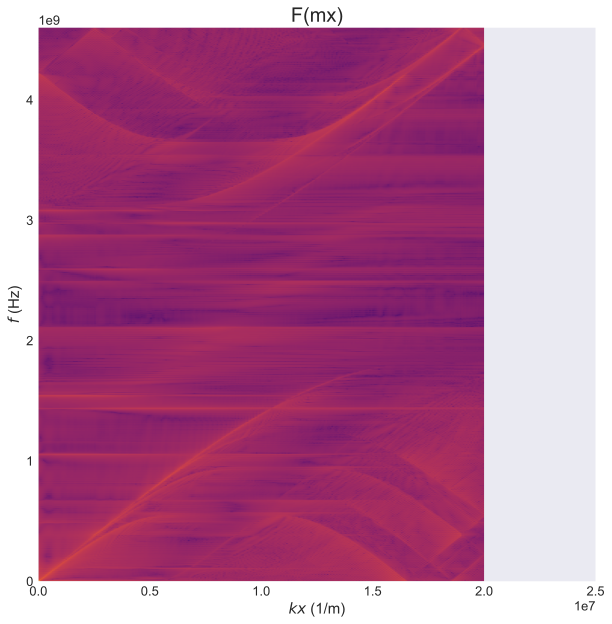

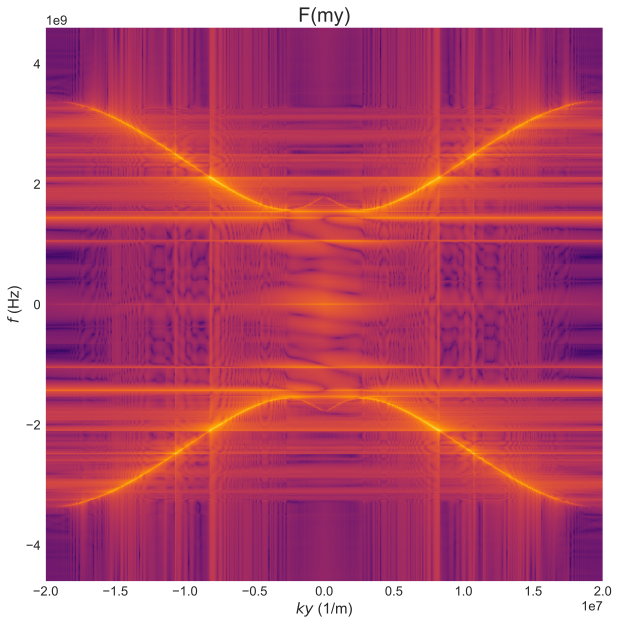

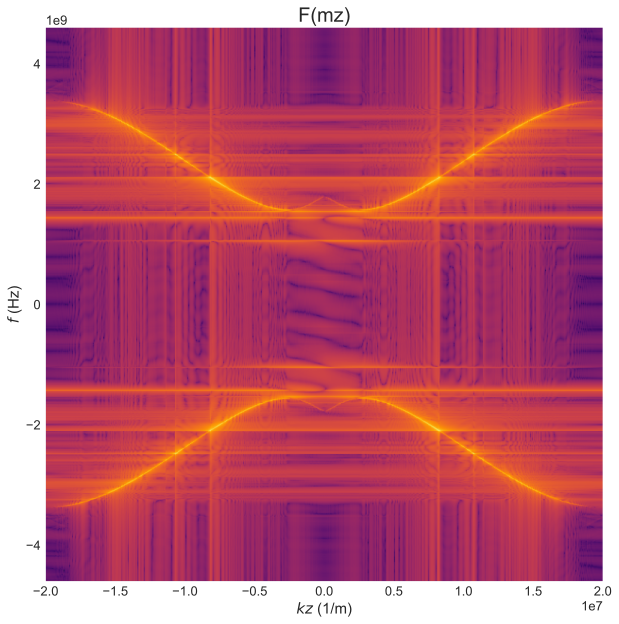

In [19]:
import matplotlib.colors as colors

# Show the intensity plot of the 2D FFT
plt.figure(figsize=(10, 10))
plt.title('F(mx)')
extent = [-1/cx, 1/cx, -f_MAX, f_MAX]  # extent of k values and frequencies
plt.imshow(np.log(np.abs(m_fft_x)**2), extent=extent,
           aspect='auto', origin='lower', norm=colors.CenteredNorm(vcenter=22), cmap="inferno")
plt.ylabel("$f$ (Hz)")
plt.xlabel("$kx$ (1/m)")

# plt.xlim([0, 1/cx])
# plt.ylim([0, f_MAX])
plt.xlim([0, 25e6])
plt.ylim([0, f_MAX])


plt.figure(figsize=(10, 10))
plt.title('F(my)')
extent = [-1/cx, 1/cx, -f_MAX, f_MAX]  # extent of k values and frequencies
plt.imshow(np.log(np.abs(m_fft_y)**2), extent=extent,
           aspect='auto', origin='lower', cmap="inferno")
plt.ylabel("$f$ (Hz)")
plt.xlabel("$ky$ (1/m)")
plt.figure(figsize=(10, 10))
plt.title('F(mz)')
extent = [-1/cx, 1/cx, -f_MAX, f_MAX]  # extent of k values and frequencies
plt.imshow(np.log(np.abs(m_fft_z)**2), extent=extent,
           aspect='auto', origin='lower', cmap="inferno")
plt.ylabel("$f$ (Hz)")
plt.xlabel("$kz$ (1/m)")

In [ ]:
data=md.Data("P1")

drive = data[-1]
drive.info

{'drive_number': 44,
 'date': '2024-01-25',
 'time': '10:49:41',
 'driver': 'TimeDriver',
 't': 2e-07,
 'n': 1890,
 'n_threads': 19}

MovieWriter Pillow unavailable; using Pillow instead.


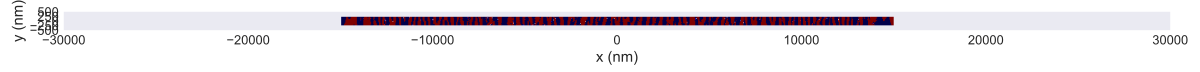

In [20]:

from celluloid import Camera
fig, ax = plt.subplots(figsize=(20, 5))
camera = Camera(fig)

for i in range(sampling): 
    
    data[-1][i].y.sel('z').mpl.scalar(ax=ax,cmap='seismic',interpolation='bilinear',
    colorbar=False,vmin=-10,vmax=10,multiplier=1e-9,
    )
    camera.snap()
    
    
animation=camera.animate()
filename='SW.gif'
animation.save(filename,writer='Pillow',fps=5)